# Genetik Algoritma ile Öğrenci Etüt Programı Optimizasyonu

## Senaryo 9: Öğrenci Etüt Programı Planlaması

Bu projede, bir öğrencinin sınav başarısını maksimize etmek amacıyla matematik ve fen dersleri için ayıracağı etüt saatlerini optimize etmesi problemi ele alınmaktadır. Problem, belirli zaman ve ders kısıtları altında başarı skorunu en üst düzeye çıkaracak şekilde modellenmiş ve **Genetik Algoritma (GA)** yöntemi ile çözülmüştür.

### Problem Tanımı

**Amaç Fonksiyonu:**

$$y = 4x_1 + 5x_2 - 0.5x_1^2 - 0.2x_2^2$$

Yukarıdaki amaç fonksiyonu, öğrencinin sınav başarı skorunu ifade etmektedir. Bu fonksiyonun maksimum değerini veren $x_1$ ve $x_2$ değerlerinin bulunması hedeflenmektedir.

**Karar Değişkenleri:**
- $x_1$: Matematik etüt süresi (saat) → [0, 10]
- $x_2$: Fen etüt süresi (saat) → [0, 10]

**Kısıtlar:**
1. **Toplam Süre Kısıtı**: $x_1 + x_2 \le 12$
   - Matematik ve Fen derslerine ayrılan toplam süre 12 saati geçmemelidir.

2. **Minimum Fen Kısıtı**: $x_2 \ge 2$
   - Fen dersine en az 2 saat ayrılmalıdır.

### Çözüm Yaklaşımı

Bu problem, kısıtlı bir optimizasyon problemidir. Çözüm için **Genetik Algoritma** kullanılmıştır. Kısıtları ihlal eden bireylere "Ceza Fonksiyonu" (Penalty Function) uygulanarak, bu bireylerin seçilme olasılığı düşürülmüş ve algoritmanın geçerli çözüm alanına yönelmesi sağlanmıştır.

In [22]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Rastgelelik için çekirdek (seed) değerlerini sabitleyelim
random.seed(42)
np.random.seed(42)

print("Kütüphaneler yüklendi ve ayarlar yapıldı.")

Kütüphaneler yüklendi ve ayarlar yapıldı.


In [23]:
# Gerekli kütüphanelerin import edilmesi
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

# Rastgele sayı üretimi için seed belirleme (sonuçların tekrarlanabilir olması için)
np.random.seed(42)
random.seed(42)

print("Kütüphaneler başarıyla yüklendi ve ayarlar yapıldı!")

Kütüphaneler başarıyla yüklendi ve ayarlar yapıldı!


## 1. Problemin Tanımı ve Modelleme

Bu bölümde, optimizasyon probleminin matematiksel modeli oluşturulmakta ve gerekli fonksiyonlar tanımlanmaktadır.

### 1.1 Amaç Fonksiyonu ve Kısıtlar

Problemin matematiksel modeli Python fonksiyonları olarak tanımlanmaktadır. Amaç fonksiyonu başarı skorunu hesaplarken, kısıt kontrol fonksiyonları çözümün geçerliliğini denetler. Ceza fonksiyonu ise geçersiz çözümlere negatif puan vererek elenmelerini sağlar.

In [24]:
# Problem Parametreleri
SINIRLAR = [(0.0, 10.0), (0.0, 10.0)]  # x1 ve x2 için [0, 10] aralığı
MAKS_TOPLAM_SAAT = 12.0
MIN_FEN_SAATI = 2.0

def amac_fonksiyonu(x1, x2):
    """
    Amaç fonksiyonu: y = 4x₁ + 5x₂ - 0.5x₁² - 0.2x₂²
    Başarı skorunu hesaplar.
    """
    return 4 * x1 + 5 * x2 - 0.5 * x1**2 - 0.2 * x2**2

def kisit_kontrol(x1, x2):
    """
    Kısıtların sağlanıp sağlanmadığını kontrol eder.
    1. x₁ + x₂ <= 12
    2. x₂ >= 2
    """
    toplam_sure_uygun = (x1 + x2) <= MAKS_TOPLAM_SAAT
    min_fen_uygun = x2 >= MIN_FEN_SAATI
    return toplam_sure_uygun and min_fen_uygun

def ceza_fonksiyonu(x1, x2, ceza_katsayisi=50.0):
    """
    Kısıt ihlalleri için ceza puanı hesaplar.
    İhlal miktarı ile orantılı negatif bir değer döndürür.
    """
    ihlaller = []

    # 1. Toplam süre kısıtı ihlali
    if x1 + x2 > MAKS_TOPLAM_SAAT:
        ihlaller.append(x1 + x2 - MAKS_TOPLAM_SAAT)

    # 2. Minimum Fen saati kısıtı ihlali
    if x2 < MIN_FEN_SAATI:
        ihlaller.append(MIN_FEN_SAATI - x2)

    if not ihlaller:
        return 0.0

    return -ceza_katsayisi * sum(ihlaller)

# Test: Basit bir test ile fonksiyonların çalışıp çalışmadığını kontrol edelim
print(f"Test (x1=5, x2=5) Skor: {amac_fonksiyonu(5, 5)}")
print(f"Kısıt Kontrol (x1=10, x2=5): {kisit_kontrol(10, 5)}") # False olmalı (toplam > 12)

Test (x1=5, x2=5) Skor: 27.5
Kısıt Kontrol (x1=10, x2=5): False


## 2. Genetik Algoritma Yapısı

Genetik algoritmanın temel bileşenleri bu bölümde detaylı olarak açıklanmaktadır.

### 2.1 Birey ve Popülasyon

Her birey `[x1, x2]` şeklinde bir vektördür. Başlangıç popülasyonu, belirlenen sınırlar içinde rastgele oluşturulur. **Uygunluk (Fitness)** fonksiyonu, bireyin başarısını ölçer ve kısıt ihlallerini cezalandırır.

In [25]:
def birey_olustur():
    """Belirtilen sınırlar içinde rastgele bir birey [x1, x2] oluşturur."""
    x1 = np.random.uniform(SINIRLAR[0][0], SINIRLAR[0][1])
    x2 = np.random.uniform(SINIRLAR[1][0], SINIRLAR[1][1])
    return np.array([x1, x2])

def populasyon_olustur(boyut):
    """Belirtilen boyutta rastgele bir popülasyon matrisi döndürür."""
    return np.array([birey_olustur() for _ in range(boyut)])

def fitness_hesapla(birey):
    """Fitness = Amaç Fonksiyonu + Ceza"""
    x1, x2 = birey
    skor = amac_fonksiyonu(x1, x2)
    ceza = ceza_fonksiyonu(x1, x2)
    return skor + ceza

def populasyon_fitness(populasyon):
    """Tüm popülasyonun fitness değerlerini hesaplar."""
    return np.array([fitness_hesapla(b) for b in populasyon])

# Test
pop = populasyon_olustur(5)
print("Örnek Popülasyon (İlk 5 birey):\n", pop)

Örnek Popülasyon (İlk 5 birey):
 [[3.74540119 9.50714306]
 [7.31993942 5.98658484]
 [1.5601864  1.5599452 ]
 [0.58083612 8.66176146]
 [6.01115012 7.08072578]]


### 2.2 Genetik Operatörler (Seçim, Çaprazlama, Mutasyon)

Algoritmanın evrimsel sürecini yöneten operatörler şunlardır:
* **Seçim (Selection):** Turnuva yöntemi ile en iyi bireylerin seçilmesi.
* **Çaprazlama (Crossover):** İki ebeveynin genlerinin karıştırılarak yeni bireyler üretilmesi.
* **Mutasyon (Mutation):** Gen çeşitliliğini sağlamak için bireylere rastgele küçük değişiklikler yapılması.

In [26]:
def turnuva_secimi(populasyon, fitness_degerleri, k=3):
    """Rastgele k bireyden en iyisini seçer."""
    secilenler_idx = np.random.choice(len(populasyon), k, replace=False)
    en_iyi_idx = secilenler_idx[np.argmax(fitness_degerleri[secilenler_idx])]
    return populasyon[en_iyi_idx].copy()

def crossover(ebeveyn1, ebeveyn2, oran=0.5):
    """Tek noktalı çaprazlama uygular."""
    if np.random.rand() < oran:
        # Basit tek nokta (değişken sayısı az olduğu için yer değiştirme)
        cocuk1 = np.array([ebeveyn1[0], ebeveyn2[1]])
        cocuk2 = np.array([ebeveyn2[0], ebeveyn1[1]])
        return cocuk1, cocuk2
    return ebeveyn1.copy(), ebeveyn2.copy()

def mutasyon(birey, oran=0.1, siddet=0.5):
    """Genlere rastgele gürültü (Gaussian noise) ekler."""
    for i in range(len(birey)):
        if np.random.rand() < oran:
            birey[i] += np.random.normal(0, siddet)
            # Sınır kontrolü (clip) - Değerlerin [0,10] aralığında kalmasını sağlar
            birey[i] = np.clip(birey[i], SINIRLAR[i][0], SINIRLAR[i][1])
    return birey

### 2.3 Genetik Algoritma Ana Döngüsü

Bu bölümde, tanımlanan tüm operatörler bir araya getirilerek algoritmanın ana döngüsü oluşturulur. **Elitizm** kullanılarak her neslin en iyi bireyleri doğrudan bir sonraki nesle aktarılır, böylece en iyi çözüm asla kaybolmaz.

In [27]:
def genetik_algoritma(pop_boyutu=60, nesil_sayisi=80, mutasyon_orani=0.1, elitizm_sayisi=1):
    # 1. Başlangıç Popülasyonu
    populasyon = populasyon_olustur(pop_boyutu)

    gecmis_en_iyi_skorlar = []
    gecmis_en_iyi_bireyler = []

    for nesil in range(nesil_sayisi):
        # 2. Değerlendirme
        fitness_degerleri = populasyon_fitness(populasyon)

        # En iyiyi kaydet
        en_iyi_idx = np.argmax(fitness_degerleri)
        gecmis_en_iyi_skorlar.append(fitness_degerleri[en_iyi_idx])
        gecmis_en_iyi_bireyler.append(populasyon[en_iyi_idx].copy())

        # 3. Yeni Nesil (Elitizm)
        yeni_populasyon = []

        # En iyi bireyleri doğrudan aktar (Elitizm)
        sirali_idx = np.argsort(fitness_degerleri)[::-1] # Büyükten küçüğe sırala
        for i in range(elitizm_sayisi):
            yeni_populasyon.append(populasyon[sirali_idx[i]].copy())

        # Geri kalanı üret (Seçim, Çaprazlama, Mutasyon)
        while len(yeni_populasyon) < pop_boyutu:
            e1 = turnuva_secimi(populasyon, fitness_degerleri)
            e2 = turnuva_secimi(populasyon, fitness_degerleri)

            c1, c2 = crossover(e1, e2)

            yeni_populasyon.append(mutasyon(c1, mutasyon_orani))
            if len(yeni_populasyon) < pop_boyutu:
                yeni_populasyon.append(mutasyon(c2, mutasyon_orani))

        populasyon = np.array(yeni_populasyon)

        # Her 10 nesilde bir ilerlemeyi yazdır
        if (nesil+1) % 10 == 0:
            print(f"Nesil {nesil+1}: En İyi Skor = {gecmis_en_iyi_skorlar[-1]:.4f}")

    # Sonuç
    final_en_iyi_idx = np.argmax(gecmis_en_iyi_skorlar)
    return gecmis_en_iyi_bireyler[final_en_iyi_idx], gecmis_en_iyi_skorlar[final_en_iyi_idx], gecmis_en_iyi_skorlar

print("Algoritma fonksiyonu hazır.")

Algoritma fonksiyonu hazır.


## 3. Uygulama ve Sonuçlar

Algoritma belirlenen parametrelerle çalıştırılır ve elde edilen en iyi çözüm (Matematik ve Fen süreleri) raporlanır. Ayrıca sonuçların kısıtları sağlayıp sağlamadığı kontrol edilir.

In [28]:
print("Optimizasyon Başlatılıyor...\n")

en_iyi_birey, en_iyi_skor, skor_gecmisi = genetik_algoritma(
    pop_boyutu=60,
    nesil_sayisi=100,
    mutasyon_orani=0.1,
    elitizm_sayisi=2
)

x1_opt, x2_opt = en_iyi_birey

print("\n" + "="*40)
print("SONUÇLAR")
print("="*40)
print(f"Matematik Süresi (x1): {x1_opt:.4f} saat")
print(f"Fen Süresi (x2)      : {x2_opt:.4f} saat")
print(f"Toplam Süre          : {x1_opt + x2_opt:.4f} saat")
print(f"Maksimum Skor        : {en_iyi_skor:.4f}")
print(f"Kısıtlar Sağlandı mı?: {kisit_kontrol(x1_opt, x2_opt)}")

Optimizasyon Başlatılıyor...

Nesil 10: En İyi Skor = 35.9409
Nesil 20: En İyi Skor = 35.9722
Nesil 30: En İyi Skor = 36.2292
Nesil 40: En İyi Skor = 36.2536
Nesil 50: En İyi Skor = 36.2539
Nesil 60: En İyi Skor = 36.2539
Nesil 70: En İyi Skor = 36.2539
Nesil 80: En İyi Skor = 36.2539
Nesil 90: En İyi Skor = 36.2539
Nesil 100: En İyi Skor = 36.2539

SONUÇLAR
Matematik Süresi (x1): 3.0915 saat
Fen Süresi (x2)      : 8.9060 saat
Toplam Süre          : 11.9975 saat
Maksimum Skor        : 36.2539
Kısıtlar Sağlandı mı?: True


## 4. Görselleştirme ve Analiz

### 4.1 Skor Gelişimi ve Çözüm Uzayı

Algoritmanın başarısını ve çözümün doğruluğunu göstermek için iki grafik çizdirilmektedir:
1. **Skor Gelişimi:** Nesiller boyunca en iyi skorun nasıl değiştiğini (iyileştiğini) gösterir.
2. **Çözüm Uzayı (Kontur Grafiği):** Amaç fonksiyonunun haritası üzerinde kısıt sınırları ve bulunan en iyi çözüm noktası gösterilir.

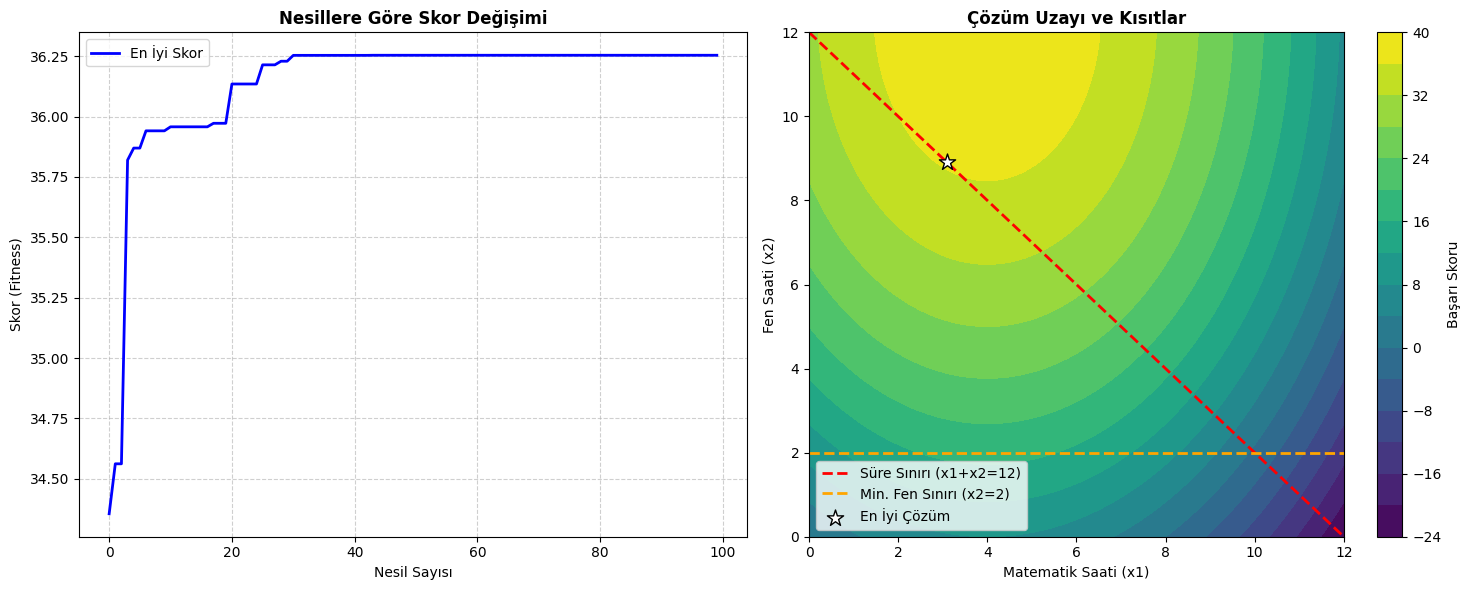

In [29]:
# Grafik Çizimi - Yan Yana (Side by Side)
plt.figure(figsize=(15, 6)) # Genişlik: 15, Yükseklik: 6 (Yan yana sığması için geniş tutuldu)

# --- 1. GRAFİK (SOL): Skor Gelişimi ---
plt.subplot(1, 2, 1) # 1 satır, 2 sütunluk düzenin 1. grafiği
plt.plot(skor_gecmisi, linewidth=2, color='blue', label='En İyi Skor')
plt.title("Nesillere Göre Skor Değişimi", fontsize=12, fontweight='bold')
plt.xlabel("Nesil Sayısı")
plt.ylabel("Skor (Fitness)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- 2. GRAFİK (SAĞ): Amaç Fonksiyonu ve Kısıtlar ---
plt.subplot(1, 2, 2) # 1 satır, 2 sütunluk düzenin 2. grafiği

# Kontur verilerini hazırla
x1_aralik = np.linspace(0, 12, 100)
x2_aralik = np.linspace(0, 12, 100)
X1, X2 = np.meshgrid(x1_aralik, x2_aralik)
Z = 4 * X1 + 5 * X2 - 0.5 * X1**2 - 0.2 * X2**2

# Kontur haritasını çiz
kontur = plt.contourf(X1, X2, Z, levels=20, cmap='viridis')
plt.colorbar(kontur, label='Başarı Skoru')

# Kısıt Çizgileri
# 1. Kısıt: x1 + x2 <= 12 (Sınır çizgisi: x2 = 12 - x1)
plt.plot(x1_aralik, 12 - x1_aralik, 'r--', linewidth=2, label='Süre Sınırı (x1+x2=12)')

# 2. Kısıt: x2 >= 2 (Sınır çizgisi: x2 = 2)
plt.axhline(y=2, color='orange', linestyle='--', linewidth=2, label='Min. Fen Sınırı (x2=2)')

# En İyi Çözümü İşaretle
plt.scatter([x1_opt], [x2_opt], color='white', s=150, edgecolors='black', marker='*', label='En İyi Çözüm', zorder=5)

# Grafik Ayarları
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.xlabel("Matematik Saati (x1)")
plt.ylabel("Fen Saati (x2)")
plt.title("Çözüm Uzayı ve Kısıtlar", fontsize=12, fontweight='bold')
plt.legend(loc='lower left') # Lejantı sol alt köşeye koy

plt.tight_layout() # Grafikler birbirine girmesin diye otomatik düzenle
plt.show()